In [23]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [24]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [25]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [26]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [27]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [28]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [29]:
def model_loss(state_size, action_size, hidden_size, 
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    Qs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, # GAN
                                                                   labels=rates)) # 0-1
    ############################################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    nextQs_logits = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                                  action_size=action_size, reuse=True)
    nextQs = tf.reshape(nextQs_logits, shape=[-1]) * dones
    targetQs = rewards + (0.99 * nextQs)
    aloss2 = tf.reduce_mean(tf.square(Qs - targetQs)) # DQN
    return actions_logits, aloss, dloss, aloss2

In [30]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [31]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [32]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [33]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [34]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [35]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [36]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 1.0
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], 
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 aloss:1.4341 dloss:0.7315 aloss2:0.8299 exploreP:0.9979
Episode:1 meanR:20.0000 R:19.0000 rate:0.0380 aloss:1.4359 dloss:0.7266 aloss2:0.8491 exploreP:0.9960
Episode:2 meanR:21.0000 R:23.0000 rate:0.0460 aloss:1.4278 dloss:0.7217 aloss2:0.8735 exploreP:0.9938
Episode:3 meanR:22.0000 R:25.0000 rate:0.0500 aloss:1.4160 dloss:0.7175 aloss2:0.8915 exploreP:0.9913
Episode:4 meanR:25.2000 R:38.0000 rate:0.0760 aloss:1.4139 dloss:0.7120 aloss2:0.9201 exploreP:0.9876
Episode:5 meanR:28.8333 R:47.0000 rate:0.0940 aloss:1.4062 dloss:0.7062 aloss2:0.9521 exploreP:0.9830
Episode:6 meanR:27.1429 R:17.0000 rate:0.0340 aloss:1.4027 dloss:0.6989 aloss2:0.9793 exploreP:0.9814
Episode:7 meanR:27.8750 R:33.0000 rate:0.0660 aloss:1.4001 dloss:0.6937 aloss2:1.0061 exploreP:0.9782
Episode:8 meanR:26.1111 R:12.0000 rate:0.0240 aloss:1.3959 dloss:0.6902 aloss2:1.0257 exploreP:0.9770
Episode:9 meanR:24.9000 R:14.0000 rate:0.0280 aloss:1.3972 dloss:0.6895 aloss2:1.0

Episode:80 meanR:29.0123 R:60.0000 rate:0.1200 aloss:1.3814 dloss:0.4451 aloss2:3.9407 exploreP:0.7927
Episode:81 meanR:28.9756 R:26.0000 rate:0.0520 aloss:1.3742 dloss:0.4492 aloss2:4.1022 exploreP:0.7906
Episode:82 meanR:29.1325 R:42.0000 rate:0.0840 aloss:1.3773 dloss:0.4428 aloss2:4.2843 exploreP:0.7874
Episode:83 meanR:29.1071 R:27.0000 rate:0.0540 aloss:1.3797 dloss:0.4352 aloss2:4.2389 exploreP:0.7853
Episode:84 meanR:28.9647 R:17.0000 rate:0.0340 aloss:1.3656 dloss:0.4367 aloss2:4.3649 exploreP:0.7839
Episode:85 meanR:28.8837 R:22.0000 rate:0.0440 aloss:1.3753 dloss:0.4248 aloss2:4.4204 exploreP:0.7822
Episode:86 meanR:28.9425 R:34.0000 rate:0.0680 aloss:1.3700 dloss:0.4326 aloss2:4.4939 exploreP:0.7796
Episode:87 meanR:29.0227 R:36.0000 rate:0.0720 aloss:1.3802 dloss:0.4150 aloss2:4.6442 exploreP:0.7769
Episode:88 meanR:28.8876 R:17.0000 rate:0.0340 aloss:1.3717 dloss:0.4290 aloss2:4.5494 exploreP:0.7756
Episode:89 meanR:28.8556 R:26.0000 rate:0.0520 aloss:1.3799 dloss:0.4277 

Episode:159 meanR:54.9500 R:48.0000 rate:0.0960 aloss:1.3664 dloss:0.4024 aloss2:7.9985 exploreP:0.4963
Episode:160 meanR:55.3700 R:68.0000 rate:0.1360 aloss:1.3645 dloss:0.4066 aloss2:8.0858 exploreP:0.4930
Episode:161 meanR:55.6700 R:43.0000 rate:0.0860 aloss:1.3735 dloss:0.3938 aloss2:8.1139 exploreP:0.4910
Episode:162 meanR:55.7600 R:34.0000 rate:0.0680 aloss:1.3713 dloss:0.4358 aloss2:8.0666 exploreP:0.4893
Episode:163 meanR:57.1500 R:152.0000 rate:0.3040 aloss:1.3695 dloss:0.4083 aloss2:7.8363 exploreP:0.4821
Episode:164 meanR:57.5000 R:50.0000 rate:0.1000 aloss:1.3699 dloss:0.3969 aloss2:7.8753 exploreP:0.4798
Episode:165 meanR:57.6600 R:48.0000 rate:0.0960 aloss:1.3703 dloss:0.3982 aloss2:7.8316 exploreP:0.4775
Episode:166 meanR:58.5500 R:104.0000 rate:0.2080 aloss:1.3722 dloss:0.3942 aloss2:7.8740 exploreP:0.4727
Episode:167 meanR:59.4300 R:117.0000 rate:0.2340 aloss:1.3700 dloss:0.4010 aloss2:7.9068 exploreP:0.4673
Episode:168 meanR:59.9700 R:68.0000 rate:0.1360 aloss:1.3665 

Episode:237 meanR:208.1500 R:500.0000 rate:1.0000 aloss:1.3643 dloss:0.5927 aloss2:4.1828 exploreP:0.0840
Episode:238 meanR:212.4600 R:500.0000 rate:1.0000 aloss:1.3600 dloss:0.5789 aloss2:4.1595 exploreP:0.0804
Episode:239 meanR:215.9000 R:500.0000 rate:1.0000 aloss:1.3574 dloss:0.5716 aloss2:4.0990 exploreP:0.0770
Episode:240 meanR:220.3400 R:500.0000 rate:1.0000 aloss:1.3576 dloss:0.5859 aloss2:4.0938 exploreP:0.0737
Episode:241 meanR:223.5600 R:377.0000 rate:0.7540 aloss:1.3611 dloss:0.5810 aloss2:3.9996 exploreP:0.0714
Episode:242 meanR:225.5400 R:238.0000 rate:0.4760 aloss:1.3534 dloss:0.5734 aloss2:3.9181 exploreP:0.0699
Episode:243 meanR:228.3900 R:336.0000 rate:0.6720 aloss:1.3546 dloss:0.5731 aloss2:4.0134 exploreP:0.0679
Episode:244 meanR:233.0400 R:500.0000 rate:1.0000 aloss:1.3516 dloss:0.5875 aloss2:4.0505 exploreP:0.0651
Episode:245 meanR:236.3400 R:482.0000 rate:0.9640 aloss:1.3499 dloss:0.6145 aloss2:3.8520 exploreP:0.0625
Episode:246 meanR:240.4600 R:461.0000 rate:0.9

Episode:315 meanR:375.9200 R:158.0000 rate:0.3160 aloss:1.3042 dloss:0.6696 aloss2:1.3095 exploreP:0.0135
Episode:316 meanR:376.6800 R:500.0000 rate:1.0000 aloss:1.3007 dloss:0.6484 aloss2:1.2326 exploreP:0.0133
Episode:317 meanR:375.6200 R:137.0000 rate:0.2740 aloss:1.2971 dloss:0.6656 aloss2:1.1764 exploreP:0.0132
Episode:318 meanR:374.3200 R:159.0000 rate:0.3180 aloss:1.3049 dloss:0.6655 aloss2:1.2576 exploreP:0.0132
Episode:319 meanR:375.7400 R:344.0000 rate:0.6880 aloss:1.2986 dloss:0.6483 aloss2:1.2431 exploreP:0.0131
Episode:320 meanR:375.8000 R:211.0000 rate:0.4220 aloss:1.3001 dloss:0.6486 aloss2:1.2342 exploreP:0.0130
Episode:321 meanR:377.3300 R:500.0000 rate:1.0000 aloss:1.2816 dloss:0.6457 aloss2:1.1072 exploreP:0.0129
Episode:322 meanR:377.3100 R:202.0000 rate:0.4040 aloss:1.2835 dloss:0.6375 aloss2:1.0491 exploreP:0.0128
Episode:323 meanR:379.7400 R:500.0000 rate:1.0000 aloss:1.2951 dloss:0.6459 aloss2:1.0747 exploreP:0.0127
Episode:324 meanR:379.7400 R:500.0000 rate:1.0

Episode:393 meanR:392.5700 R:500.0000 rate:1.0000 aloss:1.1647 dloss:0.4298 aloss2:1.0017 exploreP:0.0102
Episode:394 meanR:392.5700 R:500.0000 rate:1.0000 aloss:1.1574 dloss:0.4024 aloss2:0.9440 exploreP:0.0101


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

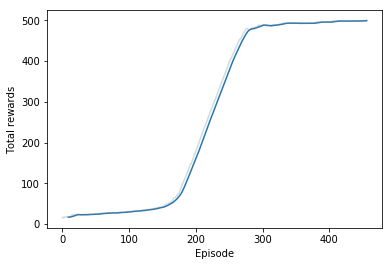

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

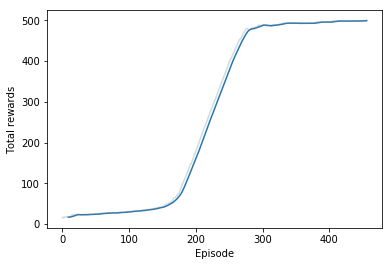

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

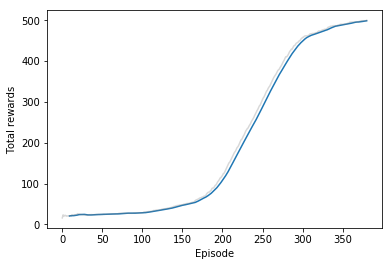

In [59]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

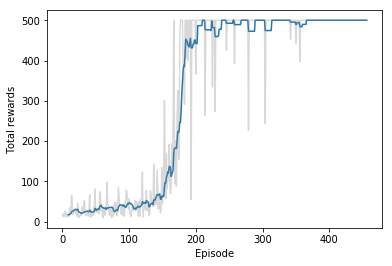

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

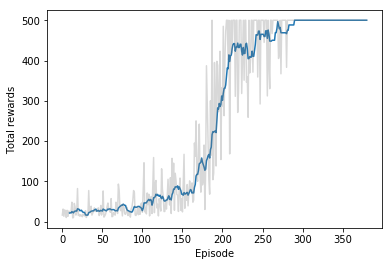

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [22]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(11):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.